# Lesson 11: Linear Regression

We aim to predict the life expenctancy of different countries during different years using socioeconomic features.  

Linear regresssion is **not compatible** with missing values or categorical variables.  

We also use Ordinary least squares via the statsmodels package. It is a **generalized linear model**. 

These models assume a Gaussian distribution of the residuals. This is something we can verify in a post-processing steps once the models have been fit to the training data.  

We can verify this with a **probability plot** that tells us how close our distribution is to normal.

We can also verify this with a **Q-Q or quantile-quantile plot**. QQ plots can be helpful in determining if data sets come from a population with a common distribution. Plots quantiles of 1st data set vs quantiles of 2nd dataset. These plots use the `yellowbrick` library. We plot **graph of residuals of training and test with a qqplot using yellowbrick**.  

We will also plot the predicted values (which rely on the linear regression model) versus the test values, which were purposefully left out of the regression process for this validation during the train-test-split.  

We also study metrics for the model performance using:  
- mean squared error (MSE)
- $R^2$ (R-squared)  

Lastly, we perform **Cross Validation**. This allows us to measure performance of a model in practice. This is done with a k-folding technique. More details presented below.

## Imports

In [1]:
# This is to change the top level directory.
%cd ..

/Users/jaimemerizalde/Desktop/Library/Machine Learning Udemy Course


In [118]:
from Library import data
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

pd.set_option("display.max_columns", None)

# Get Data

In [3]:
df = data.get_data("Datasets/LifeExpectancy.csv", index_col=[0])
df.shape

(2938, 22)

There are 22 columns / features and 2938 rows of data.

# Preprocessing

Removing missing values and categorical variables. They will not work with a linear model.  

## Missing Values

Check how many missing values.  
This will give us how many missing values, from most to least, there are in this datset.

In [134]:
df.isna().sum().sort_values(ascending=False)

population                         652
hepatitis_b                        553
gdp                                448
total_expenditure                  226
alcohol                            194
income_composition_of_resources    167
schooling                          163
thinness_5_9_years                  34
thinness__1_19_years                34
bmi                                 34
polio                               19
diphtheria                          19
life_expectancy                     10
adult_mortality                     10
hiv_aids                             0
country                              0
year                                 0
measles                              0
percentage_expenditure               0
infant_deaths                        0
status                               0
under_five_deaths                    0
dtype: int64

## Categorial Variables

In [4]:
categorical_columns = list(df.dtypes[df.dtypes == "O"].index.values)
categorical_columns

# Recast non-numerical/object columns as CAT_VARS.
for column in categorical_columns:
    df[column] = df[column].astype("category")

df.dtypes

country                            category
year                                  int64
status                             category
life_expectancy                     float64
adult_mortality                     float64
infant_deaths                         int64
alcohol                             float64
percentage_expenditure              float64
hepatitis_b                         float64
measles                               int64
bmi                                 float64
under_five_deaths                     int64
polio                               float64
total_expenditure                   float64
diphtheria                          float64
hiv_aids                            float64
gdp                                 float64
population                          float64
thinness__1_19_years                float64
thinness_5_9_years                  float64
income_composition_of_resources     float64
schooling                           float64
dtype: object

## Partitioning Dataset

Get features only and responses/targets only.

In [5]:
# Take everything except the response var.
X = df.loc[:, df.columns != "life_expectancy"]

# Now assign response variable only.
y = df["life_expectancy"]

# 67% / 33% SPLIT
# Random state is for seeding a partition. 0 - 42 are common seeds.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=42)

## Reducing Dataset

Now that we have a train-test-split dataset, we can reduce it by removing missing and non-numerical data.

In [6]:
def remove_missing_and_nonNumerical_values(X, y):
    """
    Removes missing and non-numerical values from dataframe 'X' and corresponding reponse variable y. 
    Prints minor statistics such as original shapes, categorical variables removed, and new sizes.

    Parameters
    ------
    X (pd.DataFrame): Original dataframe. Numerical and non-numerical datatypes must be pre-assigned as 
    numerical type and category.
    y (pd.DataFrame): Original response variable.

    Returns
    ------
    X (pd.DataFrame): Reduced dataframe with non nans or categorical column variables.
    y (pd.DataFrame): Reduced response variable matching corresponding rows of reduced dataframe 'X'.
    """
    print(f"Original Size X: {X.shape} y: {y.shape}")

    # Drop Categorical Values. Nonnumerical Dtypes must be 
    categorical_columns = X.dtypes[X.dtypes=="category"].index.values
    X = X.drop(columns=categorical_columns)
    print("Removed {}".format(categorical_columns))

    # Drop Missing Values.
    X = X.dropna()
    # Make sure you reduce y as well, since the above is a row-reduction technique.
    y = y[X.index]
    print(f"New Size X: {X.shape} y: {y.shape}")
    return X, y

In [7]:
X_train, y_train = remove_missing_and_nonNumerical_values(X_train, y_train)
X_test, y_test = remove_missing_and_nonNumerical_values(X_test, y_test)

Original Size X: (1968, 21) y: (1968,)
Removed ['country' 'status']
New Size X: (1123, 19) y: (1123,)
Original Size X: (970, 21) y: (970,)
Removed ['country' 'status']
New Size X: (526, 19) y: (526,)


In [ ]:
# data = X_train.copy(deep=True)
# data[y_train.name] = y_train
# data.to_csv("X_y_training_data.csv")

# data = X_test.copy(deep=True)
# data[y_test.name] = y_test
# data.to_csv("X_y_test_data.csv")

# Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression 
 
# Get the model. 
linear_regression = LinearRegression()

# Train the model with our training data.
# This sets the weights for the model which is stored in linear_regression object.
linear_regression.fit(X_train, y_train)

# Check some early prediction results based on this fit.
y_verify_pred = pd.DataFrame(linear_regression.predict(X_train))

(y_verify_pred - y_train)[0]

0        6.490100
1       -0.863201
2        9.087534
3        4.605914
4       -9.110116
          ...    
1118     1.205385
1119    13.913826
1120    -6.043233
1121    14.704313
1122    -7.002909
Name: 0, Length: 1123, dtype: float64

## Accessing Regression Weights

In [9]:
weights = linear_regression.coef_
weights

# Remember intercept is the expected (mean) value of response variable when X is zero.
intercept = linear_regression.intercept_
intercept

331.8056386872758

## Regression with Generalized Linear Model 

In [84]:
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm

# Call and train stats OLS linear regression model.
glm = sm.OLS(y_train, sm.add_constant(X_train))

glm_fitted = glm.fit() # Fit model to the training data provided to the object.
glm_fitted.summary() # Show summary statistics of trained model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     281.4
Date:                Sat, 17 May 2025   Prob (F-statistic):               0.00
Time:                        20:10:57   Log-Likelihood:                -3054.1
No. Observations:                1123   AIC:                             6148.
Df Residuals:                    1103   BIC:                             6249.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             331.8056     58.609      5.661      0.000     216.808     446.803
year                               -0.1388      0.029     -4.744      0.000      -0.196      -0.081
adult_mortality                    -0.0165      0.001    -13.942      0.000      -0.019      -0.014
infant_deaths                       0.0985      0.014      6.915      0.000       0.071       0.126
alcohol                            -0.1155      0.040     -2.916      0.004      -0.193      -0.038
percentage_expenditure              0.0003      0.000      1.113      0.266      -0.000       0.001
hepatitis_b                        -0.0040      0.006     -0.700      0.484      -0.015       0.007
measles                         -1.998e-05   1.49e-05     -1.344      0.179   -4.92e-05    9.18e-06
bmi                                 0.0264      0.008      3.466      0.001       0.011       0.041
under_five_deaths                  -0.0717      0.010     -7.065      0.000      -0.092      -0.052
polio                               0.0014      0.006      0.214      0.831      -0.011       0.014
total_expenditure                   0.0595      0.050      1.178      0.239      -0.040       0.159
diphtheria                          0.0144      0.007      1.933      0.054      -0.000       0.029
hiv_aids                           -0.4456      0.022    -20.234      0.000      -0.489      -0.402
gdp                              2.718e-05   4.47e-05      0.609      0.543   -6.04e-05       0.000
population                      -3.213e-09    2.7e-09     -1.191      0.234   -8.51e-09    2.08e-09
thinness__1_19_years               -0.0127      0.065     -0.196      0.844      -0.140       0.114
thinness_5_9_years                 -0.0831      0.064     -1.290      0.197      -0.209       0.043
income_composition_of_resources    10.6726      1.025     10.413      0.000       8.662      12.684
schooling                           0.9519      0.075     12.707      0.000       0.805       1.099
==============================================================================
Omnibus:                       24.164   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.518
Skew:                          -0.113   Prob(JB):                     2.15e-10
Kurtosis:                       3.949   Cond. No.                     3.02e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model Analysis and Validation

## Gaussian Distribution of Residuals

### Histogram Check

Want these to be as Gaussian / Normal as possible.

/var/folders/v3/j0_twvc12kb14hzn7ps4qy340000gn/T/ipykernel_31549/1404461134.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(glm_fitted.resid, bins=30)
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


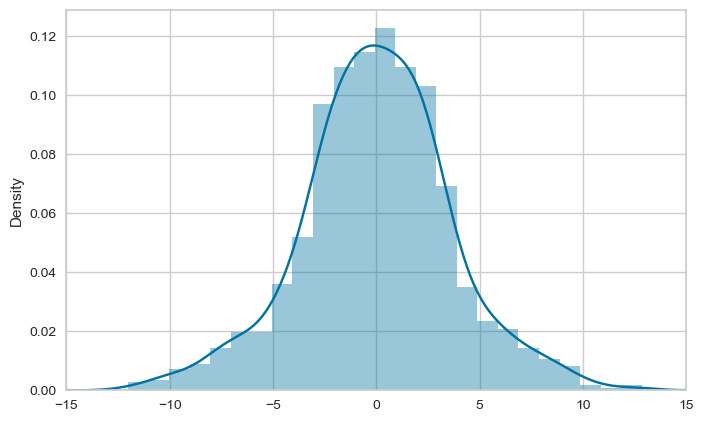

/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


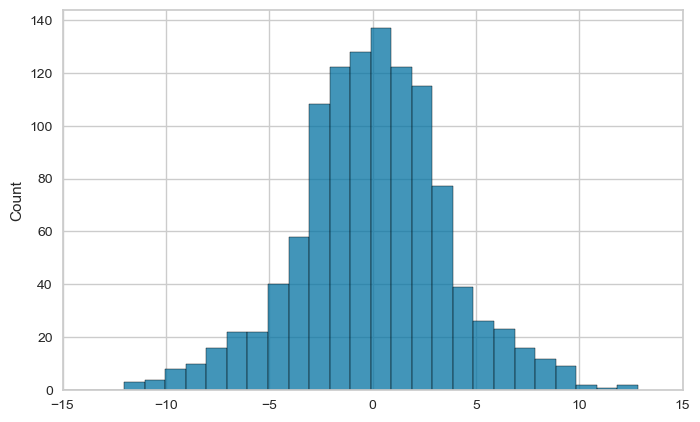

In [85]:
fig, ax = plt.subplots(figsize=(8, 8 / 1.618));
ax.set_xlim([-15, 15])
sns.distplot(glm_fitted.resid, bins=30)
plt.show()

fig, ax = plt.subplots(figsize=(8, 8 / 1.618));
sns.histplot(glm_fitted.resid, bins=30);
ax.set_xlim([-15, 15])
plt.show()

### Probability Plot Check

Want this to be as linear as possible. It is plotting the residual data versus an ideal normal distribution.

((array([-3.23088511, -2.96820298, -2.82177751, ...,  2.82177751,
          2.96820298,  3.23088511]),
  array([-16.98607418, -12.01105412, -11.33471521, ...,  11.07616836,
          12.36369399,  12.83749939])),
 (3.661620578581566, 9.69343549279322e-10, 0.9947688098696434))

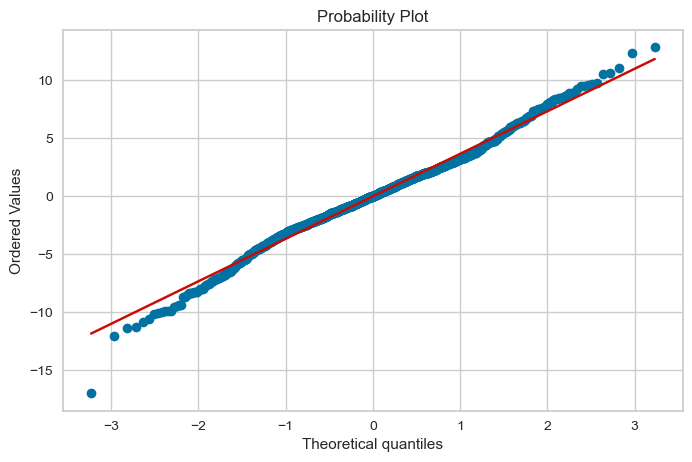

In [87]:
from scipy import stats

fig, ax = plt.subplots(figsize=(8, 8 / 1.618));
stats.probplot(glm_fitted.resid, plot=plt)

These plots confirm we have a relatively well-defined Gaussian distribution for the residuals. The more linear the probability plot, the better.

### QQ Plot Check

We will do residuals plots using the **yellowbrick** library. The residuals plot can be used to plot both a histogram of the training and test data of the linear regression model used and a QQ plot. 

This **yellowbrick** library applies specifically to scikit-learn regressors.

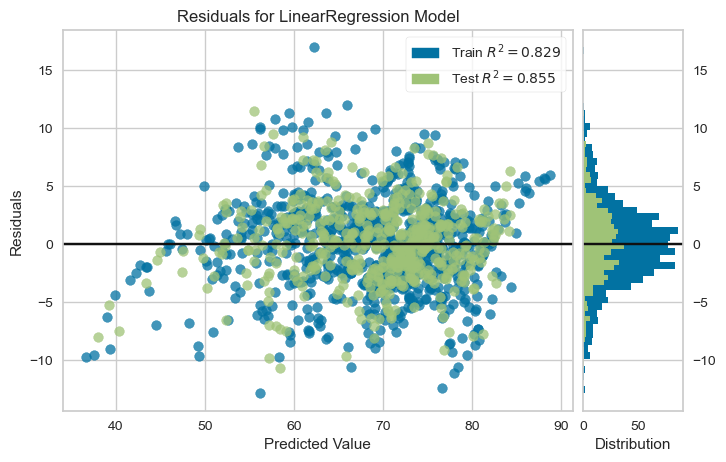

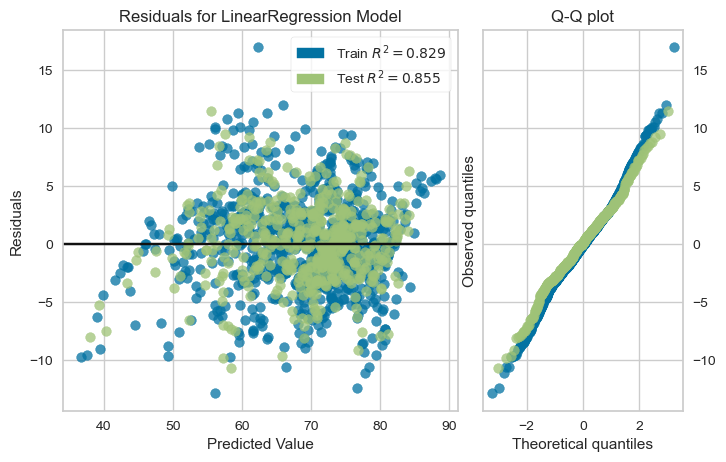

In [57]:
from yellowbrick.regressor import residuals_plot

plt.figure(figsize=(8, 8 / 1.618))
visualizer = residuals_plot(linear_regression, X_train, y_train, X_test, y_test, is_fitted=True)
plt.show()

plt.figure(figsize=(8, 8 / 1.618))
visualizer = residuals_plot(linear_regression, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False)
plt.show()

### Predicted vs Trained Plot Check 

Idea here is to perform a visual check on the actual predicted values coming from the fitting versus the test values that were not involved in the training. The more closely this is aligned to being linear, the better the result.  

This result tells us we did a pretty good job fitting the data with this model. 

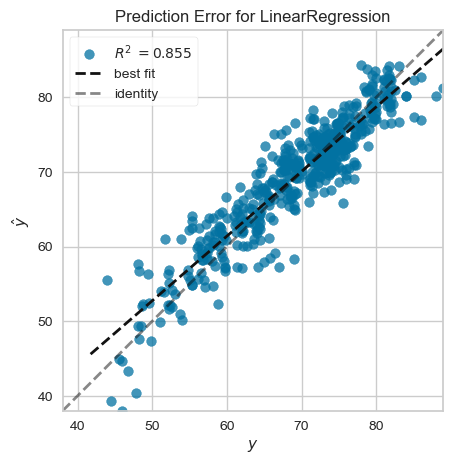

In [80]:
from yellowbrick.regressor import prediction_error
plt.figure(figsize=(8, 8 / 1.618));
visualizer = prediction_error(linear_regression, X_test, y_test, is_fitted=True)

## Metrics

Metrics can be used to measure the performance of the regression model.

### Normalized Mean Squared Error (norm-MSE)

Remember:  

\begin{align}
    norm\_MSE(t, y) = \frac{MSE(t, y)}{\sigma^2(t)} \\
    \text{where \textbf{MEAN SQUARED ERROR:}} \nonumber\\
    MSE(t, y) = \frac{1}{N} \sum_{i=1}^N (t - y(x; w))^2
\end{align}

In [105]:
# Build the MSE:
from sklearn.metrics import mean_squared_error
import numpy as np

# Get total number of training samples.
N = X_train.shape[0]

# Get the prediction using the stats model:
y_hat = glm_fitted.predict(sm.add_constant(X_train))

# Calculate MSE:
mse_stat = ((y_hat - y_train) ** 2).sum()/ N
print(f"MSE with the stats model (OLS): {mse_stat}")

# Get MSE using Scikit-learn:
mse_sk = mean_squared_error(y_train, y_hat)
print(f"MSE w scikitlearn: {mse_sk}")

# Now calculate normalized MSE:
# Calculate estimated variance: sigma(t):
sigma = np.var(y_train)
norm_mse = mse_stat / sigma
print(f"Normalized MSE: {norm_mse}.")

MSE with the stats model (OLS): 13.480918067442293
MSE w scikitlearn: 13.480918067442293
Normalized MSE: 0.1710415020528834.


### R-squared (R^2)

R-squared is obtained by subtracting the normalized MSE from 1. It represents the porportion of the target variability that the model explains.

\begin{align}
    R^2 &= 1 - norm\_MSE(t, y) \\[0.25cm]
    &= 1 - \frac{MSE(t, y)}{\sigma^2(t)}

\end{align}

In [114]:
from sklearn.metrics import r2_score

R_squared = 1 - norm_mse
print(f"R-squared: {R_squared}.")

# Alternatively, we can use sci-kit learn.
R_squared_sk = r2_score(y_train, y_hat)
print(f"R-squared via scikit-learn: {R_squared_sk}.")


R-squared: 0.8289584979471166.
R-squared via scikit-learn: 0.8289584979471165.


# Cross Validation

In cross validation, we want to measure how good the model is. The training set cannot be used for obvious reasons (the model was specifically calibrated on this information, so it is the best fit in this case). We **move away from using the test set at the very end**, so we can simulate the model run with untouched/naive data.  

Cross validation will use stricly the data in the training set, but it will further subdivide it into two more categories: Subets for training, and subsets testing. This is done via a k-folding techinque.

<img src="k_fold_cross_validation.png" width="500" height="350"/>
<!-- /Users/jaimemerizalde/Desktop/Library/Machine Learning Udemy Course/Lesson 11 - Linear Regression/k_fold_cross_validation.png -->

In [131]:
from sklearn.model_selection import KFold

# Start the cross validation metrics DF:
cross_validation_metrics = pd.DataFrame(
    columns=["MSE", "norm_MSE", "R2"]
)

# Perform K-fold.
# Instantiate a KFold object with 5 splits.
# This really only contains information about INDICES of the folds, not the DATA itself, you have to 
# call in the data using the index information provided by the KFold split. These will all come
# from the X_train data set, NOT THE TEST DATASET!! Rememember, that is not used until the final
# verification. 
kfold = KFold(n_splits=5)

# Apply this split to the training data. 
i = 1
for train_index, test_index in kfold.split(X_train):
    print(f"Split: {i}\n\tTest folds: {i}\n\tTrain folds: {[j for j in range(1, kfold.n_splits + 1) if j != i]}")

    # Get the kfold data.
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index, :]
    y_test_fold = y_train.values[test_index]

    # Perform model regression with KFold data.
    linear_regression = LinearRegression().fit(x_train_fold, y_train_fold)
    y_hat_fold = linear_regression.predict(x_test_fold)

    # Calculate Metrics of Performance
    mse_fold = mean_squared_error(y_test_fold, y_hat_fold)
    normalized_mse_fold = 1 - r2_score(y_test_fold, y_hat_fold)
    r2_fold = r2_score(y_test_fold, y_hat_fold)
    print(f"\tMSE: {mse_fold: 3.3f} normalized_MSE: {normalized_mse_fold: 3.3f} R2: {r2_fold: 3.3f}")

    # Store Cross Validation Metrics
    cross_validation_metrics.loc[f"Fold {i}", :] = [mse_fold, normalized_mse_fold, r2_fold]
    i+=1

Split: 1
	Test folds: 1
	Train folds: [2, 3, 4, 5]
	MSE:  15.126 normalized_MSE:  0.156 R2:  0.844
Split: 2
	Test folds: 2
	Train folds: [1, 3, 4, 5]
	MSE:  12.915 normalized_MSE:  0.186 R2:  0.814
Split: 3
	Test folds: 3
	Train folds: [1, 2, 4, 5]
	MSE:  15.121 normalized_MSE:  0.205 R2:  0.795
Split: 4
	Test folds: 4
	Train folds: [1, 2, 3, 5]
	MSE:  13.265 normalized_MSE:  0.170 R2:  0.830
Split: 5
	Test folds: 5
	Train folds: [1, 2, 3, 4]
	MSE:  13.932 normalized_MSE:  0.189 R2:  0.811


## Post Analysis of Cross Validation

In [ ]:
# Add the "mean" of each column as a row.
cross_validation_metrics.loc["Mean", :] = cross_validation_metrics.mean()

In [133]:
cross_validation_metrics

,MSE,norm_MSE,R2
Fold 1,15.125774,0.156393,0.843607
Fold 2,12.915315,0.185853,0.814147
Fold 3,15.1209,0.205437,0.794563
Fold 4,13.264579,0.169535,0.830465
Fold 5,13.932224,0.189038,0.810962
Mean,14.071759,0.181251,0.818749
